## Import libraries

In [237]:
!pip install numba-progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [238]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from numba import njit
from tqdm import trange, tqdm
from numba.typed import List

import networkx as nx

## Initialization and supplementary functions

In [239]:
T = 300 # K
def get_graph(file: str):
    #read graph from file
    G = nx.Graph()
    with open(file) as f:
        n, N = f.readline().split(' ') # n edges, N nodes
        n, N = int(n), int(N)
        G.add_nodes_from(np.arange(1,n+1))
        for row in f:
            node1, node2, weight = row.split(' ')
            node1, node2, weight = int(node1), int(node2), float(weight)
            G.add_weighted_edges_from([(node1, node2, weight)])
        
        assert nx.number_of_nodes(G) == n
        assert nx.number_of_edges(G) == N
    return G

In [240]:
def adj_matrix(G):
    '''
    adj: 2D adjacency matrix of a weighted graph
    neighbors: list of lists of neighbors indexes from 0 to N-1
    '''
    adj = adj_matrix = nx.to_numpy_array(G)

    neighbors = List()
    for i in range(1, nx.number_of_nodes(G)+1):
        neighbors_ = List([neighbor-1 for neighbor in nx.neighbors(G, i)])
        # for numba to interpret the type of empty list
        if len(neighbors_) == 0:
            neighbors_ = List.empty_list(nb.int64)
        neighbors.append(neighbors_)
    return adj, neighbors

In [241]:
# example
with open('test.txt', 'w') as f:
    f.write('5 5\n')
    f.write('1 2 1\n')
    f.write('1 3 2\n')
    f.write('1 4 3\n')
    f.write('2 4 4.\n')
    f.write('3 4 6.\n')
G = get_graph('test.txt')

adj, neighbors = adj_matrix(G)
print('adjacency matrix')
print(adj)
print('neigbors')
print(neighbors)

adjacency matrix
[[0. 1. 2. 3. 0.]
 [1. 0. 0. 4. 0.]
 [2. 0. 0. 6. 0.]
 [3. 4. 6. 0. 0.]
 [0. 0. 0. 0. 0.]]
neigbors
[[1, 2, 3, ...], [0, 3, ...], [0, 3, ...], [0, 1, 2, ...], [, ...], ...]


In [242]:
def system_initialization(file: str):
    '''
    N_particles: number of particles\sensors
    particles: ndarray of particles' indexes 
    is_particle: ndarray stating wether a node has a particle or it's vacant
    '''
    G = get_graph(file)
    n = nx.number_of_edges(G)
    N = nx.number_of_nodes(G)

    adj, neighbors = adj_matrix(G)
    particles = np.arange(0,N_particles)
    
    # particles initial distribution
    is_particle = np.zeros(N, dtype=bool)
    is_particle[:N_particles] = 1

    return G, adj, neighbors, particles, is_particle

@njit
def one_particle_energy(particle_number, particles, is_particle, neighbors, adj, eps, sigma):
    E = 0
    node_number = particles[particle_number]
    # determine neighbors
    for i in range(len(neighbors[node_number])):
        neighbor = neighbors[node_number][i]
        # add energy for every neighbor
        if is_particle[neighbor]:
            weight = adj[node_number, neighbor]
            E += 4*eps*((sigma/weight)**12-(sigma/weight)**6)
    return E

@njit
def total_energy(particles, is_particle, neighbors, adj, eps, sigma):
    E_tot = 0
    for i in range(N_particles):
        E_tot += one_particle_energy(i, particles, is_particle, neighbors, adj, eps, sigma)
    return E_tot/2

## Metropolis algorithm

In [243]:
@njit
def step(particles, is_particle, E_tot, Statistic, neighbors, adj, eps, sigma):
    '''
    one step of a cycle:
    main part of the metropois algorithm, consists of
    1. shifting one random particle to the neigboring node
    2. calculating the difference in energy
    3. accepting\rejecting new location of the particle
    '''

    #calculate new coordinates
    choice = np.random.choice
    old_particle_number = choice(np.arange(N_particles))
    old_node_number = particles[old_particle_number]

    if len(neighbors[old_node_number]) == 0:
        # no neighbors
        Statistic[0] +=1 
        return particles, is_particle, E_tot, Statistic

    num_of_neighbors = len(neighbors[old_node_number])
    neighboring_loc = choice(np.arange(num_of_neighbors))
    new_node_number = neighbors[old_node_number][neighboring_loc]

    if is_particle[new_node_number]:
        # chosen new location is occupied
        Statistic[1] +=1
        return particles, is_particle, E_tot, Statistic

    #shift the particle
    is_particle[old_node_number] = 0
    is_particle[new_node_number] = 1
    particles_new = np.delete(particles, old_particle_number) 
    particles_new = np.append(particles_new, new_node_number)
    # new energy
    E_new = total_energy(particles_new, is_particle, neighbors, adj, eps, sigma)
    dE = E_new - E_tot
    # accept/reject
    dp = np.exp(-dE/T)
    if dp > np.random.random():
        # accept
        E_tot = E_new
        Statistic[2] +=1
        return particles_new, is_particle, E_tot, Statistic
    else:
        # reject
        #return the particle back
        Statistic[3] +=1
        is_particle[old_node_number] = 1
        is_particle[new_node_number] = 0
        return particles, is_particle, E_tot, Statistic

In [244]:
@njit
def cycle(particles, is_particle, E_tot, neighbors, adj, steps, eps, sigma):
    '''
    cycle of metropolis algorithm's steps
    stores information about energy levels during the simulation
    '''
    Statistics = [0., # 'no_neighbors'
                  0., # 'occupied'
                  0., # 'accepted'
                  0.] # 'rejected'
    E_arr = []
    time_arr = []

    best_particle_loc = particles.copy()
    E_min = E_tot
    best_step = 0

    for i in np.arange(1,steps+1):
        particles, is_particle, E_tot, Statistics = step(particles, is_particle, E_tot, 
                                                        Statistics, neighbors, adj, eps, sigma)
        if E_tot < E_min:
            best_particle_loc = particles.copy()
            E_min = E_tot
            best_step = i

        if steps<10**4 or i%(steps//10**4) == 0:
            E_arr.append(E_tot)
            time_arr.append(i)
    for i in range(4):
        Statistics[i] /= steps
    return particles, is_particle, E_arr, E_tot, time_arr, Statistics,\
        best_particle_loc, E_min, best_step

In [245]:
def simulation(eps, sigma, adj, neighbors, particles, is_particle, steps=10**5):
    '''
    does the simulation and returns numerical results
    '''
    E_tot = total_energy(particles, is_particle, neighbors, adj, eps, sigma)
    particles, is_particle, E_arr, E_tot, time_arr, Statistics, best_particle_loc, E_min, best_step =\
        cycle(particles, is_particle, E_tot, neighbors, adj, steps, eps, sigma)

    # verification
    E_fin = total_energy(particles, is_particle, neighbors, adj, eps, sigma)
    assert np.isclose(E_fin, E_tot), f'E_fin={E_fin}, E_tot={E_tot}'

    return particles, is_particle, E_arr, time_arr, Statistics, best_particle_loc, E_min, best_step

In [263]:
def show_and_save_results(eps, sigma,E_arr, time_arr, Statistics, steps):
    '''
    visualizes the numerical data
    '''
    # plot graphs
    value = E_arr
    values_name = r'$E$'
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
    fig.suptitle(r"steps = {:<2.0e},$\varepsilon=${:2.2f}, $\sigma=${:2.3f}, success rate  = {:<1.3f}, rejection rate  = {:<1.3f}, node was occupied: {:<1.3f}, no neighbours:{:<1.2e}".format(
        steps, eps, sigma, Statistics[2],Statistics[3],Statistics[1],Statistics[0]), fontsize=20)
    ax.plot(time_arr, value)
    ax.set_ylabel(values_name,fontsize=16)
    ax.set_xlabel('steps',fontsize=16)
    plt.show()
    # save results

    # with open('steps_{:1.0e}.npy'.format(steps), 'wb') as f:
    #     np.save(f, particles)
    #     np.save(f, is_particle)
    #     np.save(f, E_arr)
    #     np.save(f, time_arr)
    #     np.save(f, np.array([steps, succ_rate]))

In [264]:
T = 1 # K
N_particles = 2
sigma, eps = 1, 100
steps=10**3
file = 'test.txt'
G, adj, neighbors, particles, is_particle = system_initialization(file)
particles, is_particle, E_arr, time_arr, Statistics, best_particle_loc, E_min, best_step =\
    simulation(eps, sigma, adj, neighbors, particles, is_particle, steps)

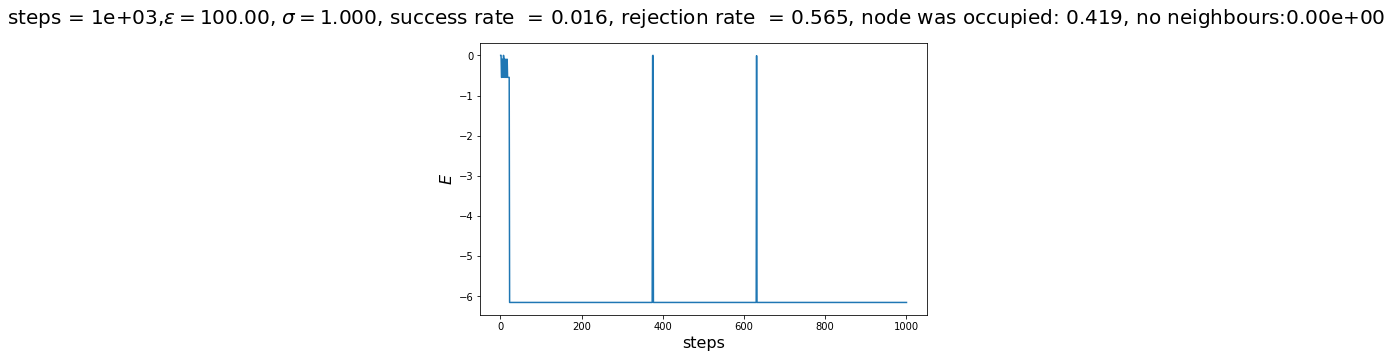

In [265]:
show_and_save_results(eps, sigma,E_arr, time_arr, Statistics, steps)

In [266]:
print('lowest energy {} was reached at time step №{} with such particle placement: {}'.format(E_min, best_step, best_particle_loc))

lowest energy -6.15234375 was reached at time step №23 with such particle placement: [0 2]
